# Data Visualization and Prediction with Python
 

In [77]:
import csv
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

## Data Formation and Parsing
Using the csv and datetime packages, we reformat the given data into proper datetime format and sort it time.

In [78]:
def get_all_cases():
    with open("info/covid19dataexport.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        all_cases = list(reader)[1:]
        # ignore the case numbers
        for i in range(len(all_cases)):
            all_cases[i] = all_cases[i][1:]
            year = int(all_cases[i][0].split('-')[0])
            month = int(all_cases[i][0].split('-')[1])
            day = int(all_cases[i][0].split('-')[2])
            formatted_date = datetime(year,month,day)
            all_cases[i][0] = formatted_date
        all_cases.sort()
        return all_cases

### Creating Cases per Day & Cases per Week
We store the data in a dictionary of {date: cases}. Other alternatives could be a list of lists, or two lists with the same length correlating to each other.

In [79]:
def get_per_day(all_cases: dict):
    case_per_day = dict()
    for case in all_cases:
        if case[0] in case_per_day:
            case_per_day[case[0]] +=1
        else:
            case_per_day[case[0]] = 1
    return case_per_day
def get_per_week(all_cases: dict):
    case_per_week = dict()
    # First case 3/06, week will start there. We will use a sliding timeframe to group these.
    # Therefore, the cases sums start at 3/13
    key = datetime(2020,3,13)
    for case in all_cases:
        while (case[0] >= key):
            key += timedelta(days=7)

        if key in case_per_week:
            case_per_week[key] +=1
        else:
            case_per_week[key] = 1
    return case_per_week


### Normal Average & Weighted Averages (bandits algorithm)
Here, we use a weighted average of the previous cases per day to predict the next upcoming day. 

In [80]:
def normal_ave(dct):
    n = 0
    ave = 0
    daily_ave = dict()
    for day in dct.keys():
        n+=1
        ave = ave + (1/n)*(dct[day]-ave)
        daily_ave[day] = ave
    return daily_ave
def weighted_ave(dct, ss):
    n = 0
    ave = 0
    daily_ave = dict()
    for day in dct.keys():
        n+=1
        ave = ave + (ss)*(dct[day]-ave)
        daily_ave[day] = ave
    return daily_ave

You can change the step size to affect how much new points of data affects our running weighted average. It should be between 0 and 1, exclusively. At a stepsize of 0, there is no change to the average. At a stepsize of 1, it follows the data perfectly.

As you can see, a normal running average is terrible for analysis. Spikes and changes in data barely affect the overall average. Using a constant step-size is a little better for modelling, as it follows the data closely. However, a weighted average does not give us much information about future predictions.

In [81]:
STEP_SIZE = 0.15

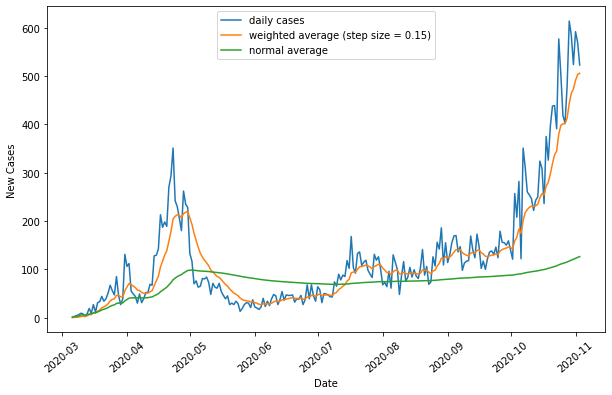

In [82]:
def plot_averages():
    all_cases = get_all_cases()
    pday = get_per_day(all_cases)
    m = normal_ave(pday)
    w = weighted_ave(pday, STEP_SIZE)
    plt.figure(figsize=(10,6))
    plt.ylabel('New Cases')
    plt.xticks(rotation=40)
    plt.xlabel('Date')

    plt.plot(pday.keys(), pday.values())
    plt.plot(w.keys(), w.values())
    plt.plot(m.keys(), m.values())
    plt.legend(["daily cases", "weighted average"+" (step size = %.2f)" %STEP_SIZE, "normal average"], loc=9)
    plt.show()
plot_averages()

### Regression Methods
Now, we will try traditional regressions. 4 polynomial regressions will be attempted to fit to a linear model.

1. DC = β0 + β1\*Days
2. DC = β0 + β1\*Days + β2\*Days^2
3. DC = β0 + β1\*Days + β2\*Days^2 + β3\*Days^3
4. DC = β0 + β1\*Days + β2\*Days^2 + β3\*Days^3 + β4\*Days^4

We first define a cost function that will return the value given the correct number of parameters.

In [83]:
def costfunc1(x,a,b):
    return (a+b*x)
def costfunc2(x,a,b,c):
    return (a+b*x+c*np.square(x))
def costfunc3(x,a,b,c,d):
    return (a+b*x+c*np.square(x)+d*np.power(x,3))
def costfunc4(x,a,b,c,d,e):
    return (a+b*x+c*np.square(x)+d*np.power(x,3)+e*np.power(x,4))

Next, we must parse the data into arrays using an integer value for days passed. getPerDayInteger will return 2 1-dimensional numpy arrays this time.

In [84]:
def getPerDayInteger(all_cases):
    pday = get_per_day(all_cases)
    list_dates = list(pday.keys())
    case_data = np.array(list(pday.values()))
    time_data = np.zeros(len(pday.keys()))
    for i in range(len(pday.keys())):
        time_data[i] = (list_dates[i]-list_dates[0]).days
    return time_data, case_data

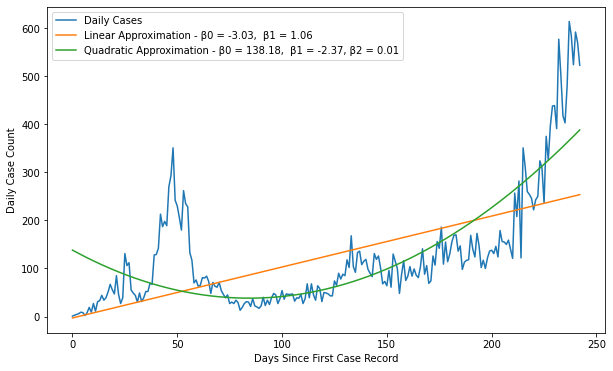

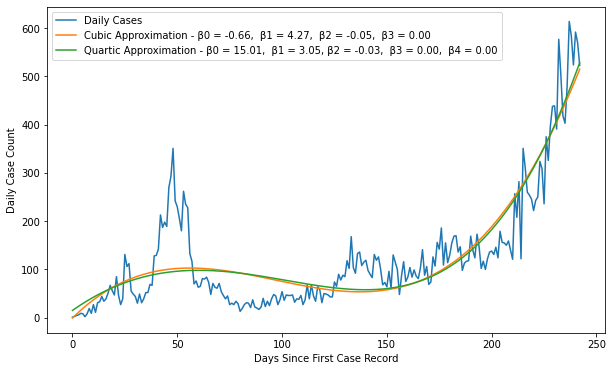

In [118]:
xdata, ydata = getPerDayInteger(get_all_cases())
popt1, pcov = curve_fit(costfunc1, xdata, ydata)
# print(popt)
DC1 = [costfunc1(i, popt1[0],popt1[1]) for i in xdata]
popt2, pcov = curve_fit(costfunc2, xdata, ydata)
# print(popt)
DC2 = [costfunc2(i, popt2[0],popt2[1],popt2[2]) for i in xdata]
plt.figure(figsize=(10,6))

plt.plot(xdata, ydata)
plt.plot(xdata, DC1)
plt.plot(xdata, DC2)
plt.xlabel("Days Since First Case Record")
plt.ylabel("Daily Case Count")
plt.legend(["Daily Cases","Linear Approximation - β0 = %.2f,  β1 = %.2f" % (popt1[0],popt1[1]), \
    "Quadratic Approximation - β0 = %.2f,  β1 = %.2f, β2 = %.2f" % (popt2[0],popt2[1],popt2[2])])


plt.show()
popt3, pcov = curve_fit(costfunc3, xdata, ydata)
#print(popt)
DC3 = [costfunc3(i, popt3[0],popt3[1],popt3[2],popt3[3]) for i in xdata]
plt.figure(figsize=(10,6))
plt.plot(xdata, ydata)
plt.plot(xdata, DC3)
popt4, pcov = curve_fit(costfunc4, xdata, ydata)
DC4 = [costfunc4(i, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]) for i in xdata]
plt.plot(xdata, DC4)
plt.xlabel("Days Since First Case Record")
plt.ylabel("Daily Case Count")
plt.legend(["Daily Cases","Cubic Approximation - β0 = %.2f,  β1 = %.2f,  β2 = %.2f,  β3 = %.2f" % (popt3[0],popt3[1],popt3[2],popt3[3]), \
    "Quartic Approximation - β0 = %.2f,  β1 = %.2f, β2 = %.2f,  β3 = %.2f,  β4 = %.2f" % (popt4[0],popt4[1],popt4[2],popt4[3],popt4[4])])
plt.show()